In [ ]:
# default_exp evaluation.causal

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Causal Evaluation

> causal

In [2]:
#export
import numpy as np
import pandas as pd

import dowhy
from dowhy import CausalModel
import dowhy.datasets 

In [3]:
#export
from enum import Enum, auto
from abc import ABC,abstractmethod
import logging

In [4]:
#export
# Avoid printing dataconversion warnings from sklearn
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [6]:
# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)

# 0. Utility Classes

In [ ]:
#This data is for testing purpuses

In [7]:
#export
class MethodName(Enum):
    propensity_score_stratification = 'backdoor.propensity_score_stratification' #<--- This is only for binary treatments
    linear_regression = 'backdoor.linear_regression'
    propensity_score_weighting = 'backdoor.propensity_score_weighting' #<--- This is only for binary treatments
    
class TargetUnit(Enum):
    atc = 'atc' #Causal effect on the control group 
    ate = 'ate' #Average Treatment Effect
    att = 'att' 
    
class RefuteEstimate(Enum):
    random_common_cause = 'random_common_cause' #Add Random Common Cause:
    add_unobserved_common_cause = 'add_unobserved_common_cause' #Add Unobserved Common Causes
    placebo_treatment_refuter = 'placebo_treatment_refuter' #Placebo Treatment
    data_subset_refuter = 'data_subset_refuter' #Removing a random subset of the data

In [8]:
MethodName.propensity_score_stratification.name

'propensity_score_stratification'

In [9]:
TargetUnit.ate.value

'ate'

In [10]:
#export
class PropensityWeighting(Enum):
    ips_weight = {'weighting_scheme':'ips_weight'} #1.Vanilla Inverse Propensity Score weighting (IPS)
    ips_normalized_weight = {'weighting_scheme':'ips_normalized_weight'} #2.Self-normalized IPS weighting (also known as the Hajek estimator)
    ips_stabilized_weight = {'weighting_scheme':'ips_stabilized_weight'} #3.Stabilized IPS weighting

In [11]:
#export
#create the abstract class for causal methods
class CausalCodeGen(ABC):
    #1. Identification
    @abstractmethod
    def identification(self):
        'identify a target estimand under the model'
        pass
    
    #2. Estimation
    @abstractmethod
    def estimation(self):
        'Estimate causal effect based on the identified estimand'
        pass
    
    #3. Refuting
    @abstractmethod
    def refuting(self):
        'Refute the obtained estimate'
        pass
    
    #4. Display
    @abstractmethod
    def display(self):
        pass

# 1. CausalCodeGen without a directed graph 
Here we specify common causes (confounders) and instruments (if any)

In [ ]:
#export
class CausalCodeGenNoGraph(CausalCodeGen):
    def __init__(self, 
            df_data, 
            treatment = ['treatment'],
            outcome = 'outcome',
            common_causes = ['confounders']
        ):
        #0. Creating the causal model
        self.model= CausalModel(
                data = df_data,
                treatment = treatment,
                outcome = outcome,
                common_causes = common_causes,
                #effect_modifiers=data["effect_modifier_names"]
            )
    
     #1. Identification
    def identification(self,proceed_when_unidentifiable=True):
        self.identified_estimand = self.model.identify_effect(proceed_when_unidentifiable=proceed_when_unidentifiable)
        #print(self.identified_estimand)
        print('Identification Done')
        pass 
    
    #2. Estimation
    def estimation(self, method_name, target_units = TargetUnit.ate.value):
        self.estimate = self.model.estimate_effect(
            self.identified_estimand,
            method_name = method_name,
            target_units = target_units
        )
        #print(self.estimate)
        #print("Causal Estimate is " + str(self.estimate.value))
        print('Estimation Done')
        pass
    
    #3. Refuting
    def refuting(self, method):
        default = "Incorrect method"
        return getattr(self, 'refuting_' + str(method), lambda: default)()

    def refuting_1(self, random_seed = 1):
        '''Adding a random common cause variable
         Does the estimation method change its estimate after 
         we add an independent random variable as a common 
         cause to the dataset? (Hint: It should not)'''
        res_random=self.model.refute_estimate(
            self.identified_estimand, 
            self.estimate, 
            method_name = RefuteEstimate.random_common_cause.value,
            random_seed = random_seed
        )
        return res_random
    
    def refuting_2(self, random_seed = 1):
        '''Adding an unobserved common cause variable
        How sensitive is the effect estimate when we add an 
        additional common cause (confounder) to the dataset that is correlated with the treatment and the outcome? 
        (Hint: It should not be too sensitive)
        '''
        res_unobserved = self.model.refute_estimate(
            self.identified_estimand, 
            self.estimate, 
            method_name=RefuteEstimate.add_unobserved_common_cause.value,
            confounders_effect_on_treatment="binary_flip", 
            confounders_effect_on_outcome="linear",
            effect_strength_on_treatment=0.01, 
            effect_strength_on_outcome=0.02,
            random_seed = random_seed
        )
        return res_unobserved
    
    def refuting_3(self, random_seed = 1):
        '''Replacing treatment with a random (placebo) variable
        What happens to the estimated causal effect when we replace 
        the true treatment variable with an independent random variable? 
        (Hint: the effect should go to zero)
        '''
        res_placebo = self.model.refute_estimate(
            self.identified_estimand, 
            self.estimate,
            method_name=RefuteEstimate.placebo_treatment_refuter.value, 
            placebo_type="permute",
            random_seed = random_seed
        )
        return res_placebo
    
    def refuting_4(self, random_seed = 1):
        '''Removing a random subset of the data
        Does the estimated effect change significantly 
        when we replace the given dataset with a randomly selected subset? 
        (Hint: It should not)
        '''
        res_subset = self.model.refute_estimate(
            self.identified_estimand, 
            self.estimate,
            method_name = RefuteEstimate.data_subset_refuter.value, 
            subset_fraction = 0.9, 
            random_seed = random_seed
        )
        return res_subset
    
    #4. Display
    def display(self):
        self.model.view_model()

### Testing CausalCodeGenNoGraph

In [ ]:
#tst
data = dowhy.datasets.linear_dataset(
        beta=10,
        num_common_causes=5,
        num_instruments = 0,
        num_effect_modifiers=0,
        num_samples=50000, 
        treatment_is_binary=True,
        num_discrete_common_causes=1
    )

In [ ]:
df = data["df"]
print(df.head())

         W0        W1        W2        W3 W4     v0          y
0 -0.217585  0.536326  0.139622  0.068094  1   True  10.520135
1 -1.899889 -0.832019 -1.851850  1.407486  0   True   2.170744
2 -0.557304 -0.237813 -0.487432  1.457238  2   True  11.748666
3 -3.146042 -1.360608 -0.029511 -0.742156  1  False -13.264900
4 -0.814657 -1.880069 -0.790882  0.642590  0  False  -3.535823


In [ ]:
#tst
obj_causalCodeGenNoGraph = CausalCodeGenNoGraph(
    df_data = df,
    treatment = data["treatment_name"],
    outcome = data["outcome_name"],
    common_causes = data["common_causes_names"],
)

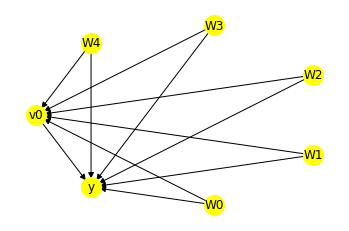

In [ ]:
#tst display
obj_causalCodeGenNoGraph.display()

In [ ]:
#tst identification
obj_causalCodeGenNoGraph.identification()

Identification Done


In [ ]:
#tst estimation binary
obj_causalCodeGenNoGraph.estimation(
    method_name=MethodName.propensity_score_stratification.value #<------- HyperParameter
)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W2,W1,W3))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W2,W1,W3,U) = P(y|v0,W0,W4,W2,W1,W3)

## Realized estimand
b: y~v0+W0+W4+W2+W1+W3
Target units: ate

## Estimate
Mean value: 10.134956483366805

Causal Estimate is 10.134956483366805
Estimation Done


In [ ]:
# tst estimation non-binary
obj_causalCodeGenNoGraph.estimation(
    #method_name=MethodName.linear_regression.value #<------- HyperParameter
    method_name=MethodName.propensity_score_weighting.value #<------- HyperParameter
)

ERROR:dowhy.causal_estimator:Propensity score methods are applicable only for binary treatments


Exception: Propensity score methods are applicable only for binary treatments

In [ ]:
#tst refuting
method = [1,2,3,4] #<----- Hyperparameter
res_method = obj_causalCodeGenNoGraph.refuting(1)
print(res_method)

Refute: Add a Random Common Cause
Estimated effect:10.134956483366805
New effect:10.133086550414514



In [ ]:
res_method = [obj_causalCodeGenNoGraph.refuting(i) for i in method]

In [ ]:
print(res_method[0])

Refute: Add a Random Common Cause
Estimated effect:1.0000328405626493
New effect:1.0000327587229392



In [ ]:
print(res_method[1])

Refute: Add an Unobserved Common Cause
Estimated effect:1.0000328405626493
New effect:0.9712936036900406



In [ ]:
print(res_method[2])

Refute: Use a Placebo Treatment
Estimated effect:1.0000328405626493
New effect:-0.0003850245605117542
p value:0.45999999999999996



In [ ]:
print(res_method[3])

Refute: Use a subset of data
Estimated effect:1.0000328405626493
New effect:1.0000328101400593
p value:0.49



# 1.1 Causal CodeGen for Instrumental Variables

In [12]:
#export
class CausalCodeGenIV(CausalCodeGen):
    def __init__(self, 
            df_data, 
            treatment = ['treatment'],
            outcome = 'outcome',
            common_causes = ['confounders'],
            instruments = ['instruments']
        ):
        #0. Creating the causal model
        self.model= CausalModel(
                data = df_data,
                treatment = treatment,
                outcome = outcome,
                common_causes = common_causes,
                instruments = instruments
                #effect_modifiers=data["effect_modifier_names"]
            )
    
     #1. Identification
    def identification(self,proceed_when_unidentifiable=True):
        self.identified_estimand = self.model.identify_effect(proceed_when_unidentifiable=proceed_when_unidentifiable)
        #print(self.identified_estimand)
        print('Identification Done')
        pass 
    
    #2. Estimation
    def estimation(self, method_name='iv.instrumental_variable', target_units = TargetUnit.ate.value):
        self.estimate = self.model.estimate_effect(
            self.identified_estimand,
            method_name = method_name,
            target_units = target_units
        )
        #print(self.estimate)
        #print("Causal Estimate is " + str(self.estimate.value))
        print('Estimation Done')
        pass
    
    #3. Refuting
    def refuting(self, method):
        default = "Incorrect method"
        return getattr(self, 'refuting_' + str(method), lambda: default)()

    def refuting_1(self, random_seed = 1):
        '''Adding a random common cause variable
         Does the estimation method change its estimate after 
         we add an independent random variable as a common 
         cause to the dataset? (Hint: It should not)'''
        res_random=self.model.refute_estimate(
            self.identified_estimand, 
            self.estimate, 
            method_name = RefuteEstimate.random_common_cause.value,
            random_seed = random_seed
        )
        return res_random
    
    def refuting_2(self, random_seed = 1):
        '''Adding an unobserved common cause variable
        How sensitive is the effect estimate when we add an 
        additional common cause (confounder) to the dataset that is correlated with the treatment and the outcome? 
        (Hint: It should not be too sensitive)
        '''
        res_unobserved = self.model.refute_estimate(
            self.identified_estimand, 
            self.estimate, 
            method_name=RefuteEstimate.add_unobserved_common_cause.value,
            confounders_effect_on_treatment="binary_flip", 
            confounders_effect_on_outcome="linear",
            effect_strength_on_treatment=0.01, 
            effect_strength_on_outcome=0.02,
            random_seed = random_seed
        )
        return res_unobserved
    
    def refuting_3(self, random_seed = 1):
        '''Replacing treatment with a random (placebo) variable
        What happens to the estimated causal effect when we replace 
        the true treatment variable with an independent random variable? 
        (Hint: the effect should go to zero)
        '''
        res_placebo = self.model.refute_estimate(
            self.identified_estimand, 
            self.estimate,
            method_name=RefuteEstimate.placebo_treatment_refuter.value, 
            placebo_type="permute",
            random_seed = random_seed
        )
        return res_placebo
    
    def refuting_4(self, random_seed = 1):
        '''Removing a random subset of the data
        Does the estimated effect change significantly 
        when we replace the given dataset with a randomly selected subset? 
        (Hint: It should not)
        '''
        res_subset = self.model.refute_estimate(
            self.identified_estimand, 
            self.estimate,
            method_name = RefuteEstimate.data_subset_refuter.value, 
            subset_fraction = 0.9, 
            random_seed = random_seed
        )
        return res_subset
    
    #4. Display
    def display(self):
        self.model.view_model()

#### Testing IV

In [13]:
#tst
data = dowhy.datasets.linear_dataset(
        beta=1,
        num_common_causes=10,
        num_instruments = 1,
        num_effect_modifiers=0,
        num_samples=50000, 
        treatment_is_binary=False,
        num_discrete_common_causes=1
    )

In [17]:
data.keys()

dict_keys(['df', 'treatment_name', 'outcome_name', 'common_causes_names', 'instrument_names', 'effect_modifier_names', 'frontdoor_variables_names', 'dot_graph', 'gml_graph', 'ate'])

In [14]:
df = data["df"]
print(df.head())

    Z0        W0        W1        W2        W3        W4        W5        W6  \
0  0.0  1.566164  1.512681  1.242919  0.013624  1.306380  1.886062  1.415980   
1  0.0  2.352194 -0.850710  0.784196  0.996262  0.944259  0.718909  0.947573   
2  1.0  0.481605  0.509863  0.999225 -1.185297  1.860904 -0.754567  2.105804   
3  0.0  0.637732  0.541335  1.181889 -1.009150  0.557356  1.076588  1.225829   
4  0.0  0.046685  0.917049  0.885750 -0.786131  0.841239 -0.181190  1.740705   

         W7        W8 W9        v0         y  
0 -0.114546  2.178110  0  4.136575  6.487519  
1  0.633531 -0.436964  0  2.315883  3.287827  
2 -0.709383 -0.642670  0  1.098459  1.932827  
3  1.060513  0.502571  2  1.935206  3.732467  
4  2.259276 -2.221843  1  0.134501  1.078550  


In [18]:
#tst
obj_causalCodeGenIV = CausalCodeGenIV(
    df_data = df,
    treatment = data["treatment_name"],
    outcome = data["outcome_name"],
    common_causes = data["common_causes_names"],
    instruments = data['instrument_names']
)

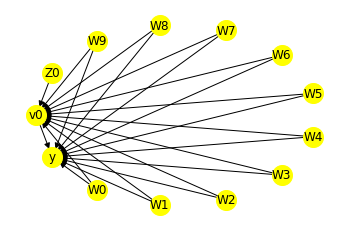

In [19]:
#tst display
obj_causalCodeGenIV.display()

In [20]:
#tst identification
obj_causalCodeGenIV.identification()

Identification Done


In [22]:
#tst estimation IV
obj_causalCodeGenIV.estimation(
    #method_name=MethodName.propensity_score_stratification.value #<------- HyperParameter
)

Estimation Done


In [24]:
# estimate
obj_causalCodeGenIV.estimate.value

In [27]:
[i for i in range(1,5)]

In [28]:
#Refuting
res_method = [obj_causalCodeGenIV.refuting(i) for i in range(1,5)]

In [30]:
print(res_method[0])

Refute: Add a Random Common Cause
Estimated effect:0.9922253774572035
New effect:0.9922253774572035



In [31]:
print(res_method[1])

Refute: Add an Unobserved Common Cause
Estimated effect:0.9922253774572035
New effect:1.0074646635100375



In [32]:
print(res_method[2])

Refute: Use a Placebo Treatment
Estimated effect:0.9922253774572035
New effect:0.0037525454546666415
p value:0.42



In [33]:
print(res_method[3])

Refute: Use a subset of data
Estimated effect:0.9922253774572035
New effect:0.9925695825064247
p value:0.41



# 2. CausalCodeGen Estimating effect of multiple treatments

In [ ]:
#export
class CausalCodeGenMultiple(CausalCodeGen):
    def __init__(self, 
            df_data, 
            treatment = ['treatment'],
            outcome = 'outcome',
            common_causes = ['confounders']
        ):
        #0. Creating the causal model
        self.model= CausalModel(
                data = df_data,
                treatment = treatment,
                outcome = outcome,
                common_causes = common_causes,
                #effect_modifiers=data["effect_modifier_names"]
            )
    
     #1. Identification
    def identification(self,proceed_when_unidentifiable=True):
        self.identified_estimand = self.model.identify_effect(proceed_when_unidentifiable=proceed_when_unidentifiable)
        print(self.identified_estimand)
        print('Identification Done')
        pass
    
    #2. Estimation
    def estimation(self, target_units = TargetUnit.ate.value):
        self.estimate = self.model.estimate_effect(
            self.identified_estimand,
            method_name =  MethodName.linear_regression.value,
            target_units = target_units,
            method_params={'need_conditional_estimates': False} #No Effect Modifiers Proposed
        )
        print(self.estimate)
        print("Causal Estimate is " + str(self.estimate.value))
        print('Estimation Done')
        pass
    
    #3. Refuting
    def refuting(self, method):
        default = "Incorrect method"
        return getattr(self, 'refuting_' + str(method), lambda: default)()

    def refuting_1(self, random_seed = 1):
        '''Adding a random common cause variable
         Does the estimation method change its estimate after 
         we add an independent random variable as a common 
         cause to the dataset? (Hint: It should not)'''
        res_random=self.model.refute_estimate(
            self.identified_estimand, 
            self.estimate, 
            method_name = RefuteEstimate.random_common_cause.value,
            random_seed = random_seed
        )
        return res_random
    
    def refuting_2(self, random_seed = 1):
        '''Adding an unobserved common cause variable
        How sensitive is the effect estimate when we add an 
        additional common cause (confounder) to the dataset that is correlated with the treatment and the outcome? 
        (Hint: It should not be too sensitive)
        '''
        res_unobserved = self.model.refute_estimate(
            self.identified_estimand, 
            self.estimate, 
            method_name=RefuteEstimate.add_unobserved_common_cause.value,
            confounders_effect_on_treatment="binary_flip", 
            confounders_effect_on_outcome="linear",
            effect_strength_on_treatment=0.01, 
            effect_strength_on_outcome=0.02,
            random_seed = random_seed
        )
        return res_unobserved
    
    def refuting_3(self, random_seed = 1):
        '''Replacing treatment with a random (placebo) variable
        What happens to the estimated causal effect when we replace 
        the true treatment variable with an independent random variable? 
        (Hint: the effect should go to zero)
        '''
        res_placebo = self.model.refute_estimate(
            self.identified_estimand, 
            self.estimate,
            method_name=RefuteEstimate.placebo_treatment_refuter.value, 
            #placebo_type="permute",
            random_seed = random_seed
        )
        return res_placebo
    
    def refuting_4(self, random_seed = 1):
        '''Removing a random subset of the data
        Does the estimated effect change significantly 
        when we replace the given dataset with a randomly selected subset? 
        (Hint: It should not)
        '''
        res_subset = self.model.refute_estimate(
            self.identified_estimand, 
            self.estimate,
            method_name = RefuteEstimate.data_subset_refuter.value, 
            subset_fraction = 0.9, 
            random_seed = random_seed
        )
        return res_subset
    
    #4. Display
    def display(self):
        self.model.view_model()

### Testing CausalCodeGenMultiple

In [ ]:
#tst
data = dowhy.datasets.linear_dataset(
        beta=1,
        num_common_causes=5,
        num_instruments = 0,
        num_effect_modifiers=0,
        num_treatments=2, #<---- Multiple Treatments
        num_samples=50000, 
        treatment_is_binary=False,
        num_discrete_common_causes=1,
        one_hot_encode=False
    )

In [ ]:
df = data["df"]
print(df.head())

         W0        W1        W2        W3 W4        v0        v1         y
0 -0.274541  0.009782  2.388789  0.730394  2  1.511253  2.677098  5.188463
1 -0.441859  0.159592  0.692636 -0.389202  0 -1.064271 -0.884891 -2.217550
2 -0.571757 -0.652518  2.326633  2.540033  3  1.422953  1.647342  4.881359
3 -1.986849 -1.588103  0.902386  0.171443  3 -0.542460  1.362156  0.977594
4 -3.139434 -0.858884  0.691831  2.276057  2 -0.260207  0.717398  0.629266


In [ ]:
#tst
obj_causalCodeGenMultiple = CausalCodeGenMultiple(
    df_data = df,
    treatment = data["treatment_name"],
    outcome = data["outcome_name"],
    common_causes = data["common_causes_names"],
)

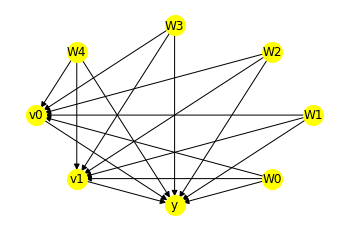

In [ ]:
#tst display
obj_causalCodeGenMultiple.display()

In [ ]:
#tst identification
obj_causalCodeGenMultiple.identification()

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                   
─────────(Expectation(y|W0,W4,W2,W1,W3))
d[v₀  v₁]                               
Estimand assumption 1, Unconfoundedness: If U→{v0,v1} and U→y then P(y|v0,v1,W0,W4,W2,W1,W3,U) = P(y|v0,v1,W0,W4,W2,W1,W3)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!

Identification Done


In [ ]:
#tst estimation binary
obj_causalCodeGenMultiple.estimation()

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                   
─────────(Expectation(y|W0,W4,W2,W1,W3))
d[v₀  v₁]                               
Estimand assumption 1, Unconfoundedness: If U→{v0,v1} and U→y then P(y|v0,v1,W0,W4,W2,W1,W3,U) = P(y|v0,v1,W0,W4,W2,W1,W3)

## Realized estimand
b: y~v0+v1+W0+W4+W2+W1+W3
Target units: ate

## Estimate
Mean value: 2.0000328649260055

Causal Estimate is 2.0000328649260055
Estimation Done


In [ ]:
res_method = obj_causalCodeGenMultiple.refuting(1)
print(res_method)

Refute: Add a Random Common Cause
Estimated effect:1.999944122500283
New effect:1.999943644474333



In [ ]:
res_method = obj_causalCodeGenMultiple.refuting(2)
print(res_method)

Refute: Add an Unobserved Common Cause
Estimated effect:1.999944122500283
New effect:1.8503717509500066



In [ ]:
res_method = obj_causalCodeGenMultiple.refuting(3)
print(res_method)

Refute: Use a Placebo Treatment
Estimated effect:2.0000328649260055
New effect:8.881784197001252e-16
p value:0.0



In [ ]:
res_method = obj_causalCodeGenMultiple.refuting(4)
print(res_method)

Refute: Use a subset of data
Estimated effect:1.999944122500283
New effect:1.999940483773885
p value:0.38

